# Overview

We will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is **Litoria fallax**, the eastern dwarf tree frog. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

The TerraClimate data is sampled at a **monthly temporal resolution**, so metrics are calculated over the time dimension to simplify the features. We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move). 

## Set up Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python --version

Python 3.7.13


In [ ]:
# install environment
!pip install contextily xarray zarr aiohttp requests pystac pystac-client planetary-computer scikit-learn fsspec shapely rioxarray stackstac xarray-spatial

#Step 1
!apt-get update
#Step 2
!apt-get install libgdal-dev -y
#Step 3
!apt-get install python-gdal -y
#Step 4
!apt-get install python-numpy python-scipy -y
#Step 5
import gdal 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 153 kB 28.0 MB/s 
     |████████████████████████████████| 1.1 MB 48.2 MB/s 
     |████████████████████████████████| 137 kB 72.9 MB/s 
     |████████████████████████████████| 140 kB 75.9 MB/s 
     |████████████████████████████████| 47 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.9 MB 35.0 MB/s 
     |████████████████████████████████| 19.3 MB 1.1 MB/s 
     |████████████████████████████████| 6.2 MB 44.9 MB/s 
     |████████████████████████████████| 144 kB 43.3 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 63.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 11.1 MB 232 kB/s 
     |████████████████████

## Load in dependencies

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = './2022-Better-Working-World-Data-Challenge/notebooks/'

# Read in data

## Response Variable

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [ ]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:  # open zip
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Spatial sampling

We will constrain our search to frogs in the 5 selected areas found between the start of 2015 to the end of 2019.

In [ ]:
target_species = 'Litoria Fallax'
# Load in data
print('Start loading...')
frogs = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019))
Sydney_frog_data = filter_bbox(frogs, bbox=(150.7-1, -33.5-1, 151.7+1, -32.5+1))
Melbourne_frog_data = filter_bbox(frogs, bbox=(144.8-1, -38.5-1, 145.8+1, -37.5+1))
Queensland_frog_data = filter_bbox(frogs, bbox=(145.0-1, -17.7-1, 146.0+1, -16.7+1))
Perth_frog_data = filter_bbox(frogs, bbox=(115.7-1, -32.5-1, 116.7+1, -31.5+1))
Brisbane_frog_data = filter_bbox(frogs, bbox=(152.6-1, -29.0-1, 153.6+1, -28.0+1))
print('Loading complete!')

Start loading...
Loading complete!


Getting a high-quality training dataset is vital to the model-building process, and the dataset will affect the model performance directly. We have placed our attention on two aspects: geographic location and size.

From the visualization below, we'll be able to see the distribution of the frog species in Australia. We found that Litoria Fallax lives near the east coast. This finding will help us balance the target variable in the training dataset and provide more flexibility on selecting the regions in our training set.

After several tries, we decided to take the test regions and increase their size to include more high-quality data. This way, we're able to generate the most accurate model.

In [ ]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params

        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

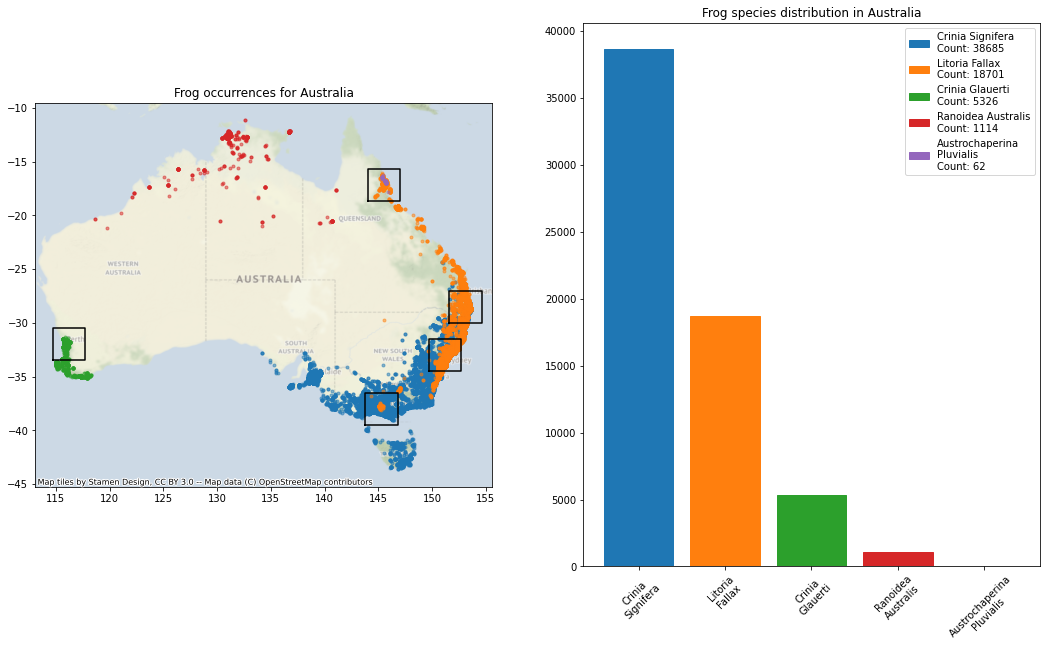

In [ ]:
test_regions = [(144.8-1, -38.5-1, 145.8+1, -37.5+1),
          (150.7-1, -33.5-1, 151.7+1, -32.5+1),  
          (152.6-1, -29.0-1, 153.6+1, -28.0+1),  
          (145.0-1, -17.7-1, 146.0+1, -16.7+1),
          (115.7-1, -32.5-1, 116.7+1, -31.5+1)]

fig, ax = plt.subplots(1,2,figsize=(18,10))
filt = frogs.continent == 'Australia'
plot_species(fig, ax, frogs[filt], 'Australia')

for i in range(len(test_regions)):
  ax[0].plot([test_regions[i][0],test_regions[i][2],test_regions[i][2],test_regions[i][0],test_regions[i][0]],
        [test_regions[i][1],test_regions[i][1],test_regions[i][3],test_regions[i][3],test_regions[i][1]],c='black')

plt.show()

### Temporal sampling

By grouping the locations together, we're able to find duplicated records in the dataset. Since different species can be discovered at the same location, it will create confusion to the model, thus decreasing the model accuracy.

In [ ]:
# Different species can be spotted at The same location
Sydney_frog_data[Sydney_frog_data.duplicated(['decimalLongitude','decimalLatitude'])].head(1)

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
971,3108869522,2019-09-22,Australia,Australia,New South Wales,-33.3249,151.365,Litoria Fallax


In [ ]:
Sydney_frog_data[lambda x: (x.decimalLatitude==-33.324900)&(x.decimalLongitude==151.365000)]

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
947,3108914117,2019-06-21,Australia,Australia,New South Wales,-33.3249,151.365,Crinia Signifera
971,3108869522,2019-09-22,Australia,Australia,New South Wales,-33.3249,151.365,Litoria Fallax
1458,3108859843,2019-09-26,Australia,Australia,New South Wales,-33.3249,151.365,Litoria Fallax
1609,3108890848,2019-08-15,Australia,Australia,New South Wales,-33.3249,151.365,Crinia Signifera
1698,3108926695,2019-10-09,Australia,Australia,New South Wales,-33.3249,151.365,Crinia Signifera
...,...,...,...,...,...,...,...,...
193069,3108927652,2019-06-11,Australia,Australia,New South Wales,-33.3249,151.365,Crinia Signifera
193070,3108898644,2019-09-06,Australia,Australia,New South Wales,-33.3249,151.365,Crinia Signifera
193175,3108886737,2019-09-30,Australia,Australia,New South Wales,-33.3249,151.365,Crinia Signifera
193443,3108879467,2019-07-21,Australia,Australia,New South Wales,-33.3249,151.365,Crinia Signifera


Based on the "eventData" attribute, we could resample the frog occurrence records to the most recent date and time when the frog was found.

In [ ]:
# Take only the most recent occurrences

Sydney_frog_data['eventDate'] = pd.to_datetime(Sydney_frog_data['eventDate'])  # convert attribute into datetime format
Sydney_frog_data = Sydney_frog_data.sort_values('eventDate').groupby(["decimalLongitude","decimalLatitude"],as_index=False).last()  # sort in ascending order to ensure function "last()" get the most recent record
print(f'Sydney_frog_data now has {Sydney_frog_data.duplicated(["decimalLongitude","decimalLatitude"]).sum()} duplicated records')  # check if there're duplicated records

Melbourne_frog_data['eventDate'] = pd.to_datetime(Melbourne_frog_data['eventDate'])
Melbourne_frog_data = Melbourne_frog_data.sort_values('eventDate').groupby(["decimalLongitude","decimalLatitude"],as_index=False).last()
print(f'Melbourne_frog_data now has {Melbourne_frog_data.duplicated(["decimalLongitude","decimalLatitude"]).sum()} duplicated records')

Queensland_frog_data['eventDate'] = pd.to_datetime(Queensland_frog_data['eventDate'])
Queensland_frog_data = Queensland_frog_data.sort_values('eventDate').groupby(["decimalLongitude","decimalLatitude"],as_index=False).last()
print(f'Queensland_frog_data now has {Queensland_frog_data.duplicated(["decimalLongitude","decimalLatitude"]).sum()} duplicated records')

Perth_frog_data['eventDate'] = pd.to_datetime(Perth_frog_data['eventDate'])
Perth_frog_data = Perth_frog_data.sort_values('eventDate').groupby(["decimalLongitude","decimalLatitude"],as_index=False).last()
print(f'Perth_frog_data now has {Perth_frog_data.duplicated(["decimalLongitude","decimalLatitude"]).sum()} duplicated records')

Brisbane_frog_data['eventDate'] = pd.to_datetime(Brisbane_frog_data['eventDate'])
Brisbane_frog_data = Brisbane_frog_data.sort_values('eventDate').groupby(["decimalLongitude","decimalLatitude"],as_index=False).last()
print(f'Brisbane_frog_data now has {Brisbane_frog_data.duplicated(["decimalLongitude","decimalLatitude"]).sum()} duplicated records')

Sydney_frog_data now has 0 duplicated records
Melbourne_frog_data now has 0 duplicated records
Queensland_frog_data now has 0 duplicated records
Perth_frog_data now has 0 duplicated records
Brisbane_frog_data now has 0 duplicated records


In [ ]:
all_frog_data_dict = {'Sydney':Sydney_frog_data,
            'Melbourne':Melbourne_frog_data,
            'Queensland':Queensland_frog_data,
            'Perth':Perth_frog_data,
            'Brisbane':Brisbane_frog_data}

## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. For a more in-depth look at the TerraClimate dataset and how to query it, see the "TerraClimate supplementary notebook".

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate.



In [ ]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

### Feature Selection

By querying all features from the dataset, we have discovered regional climate difference among the states in Australia. There are certain features that do not have high variation across different locations. These features would not help improve the model performance.

According to the boxplots, `ppt`，`soil`，`q`，`swe`，and `vpd`, fit the attributes of bad features. Therefore, we should remove those features from the predictors.

Additionally, we tried using different feature selection techniques, such as hypothesis testing and tree-based feature selection, but they provide different results. None of these approaches performs better in this case than selecting features manually.

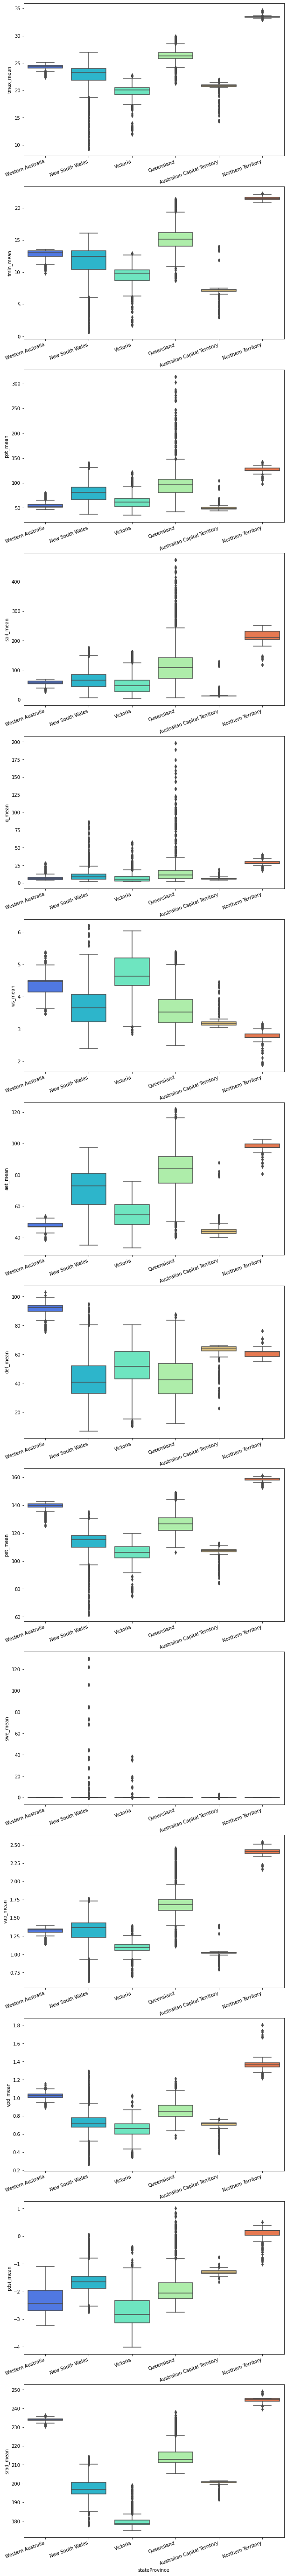

In [ ]:
# fig, ax = plt.subplots(14,1,figsize=(10,100))
# for i,feature in enumerate(features):
#   sns.boxplot(x=all_model_data['stateProvince'], y=all_model_data[feature], palette = 'rainbow', fliersize=5, ax=ax[i])
#   ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=20, horizontalalignment='right')
# plt.savefig('./Climate diff.png')
# plt.show()

Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

Since we do not use `max` and `min`, we commented them out to reduce the time loading data. We put the selected features from the previous section under `asset`.

In [ ]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{'fn':np.nanmean,'params':{}}
    # 'min':{'fn':np.nanmin,'params':{}},
    # 'max':{'fn':np.nanmax,'params':{}}
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets = ['tmax', 'tmin', 'ws', 'aet', 'def', 'pet', 'vap', 'pdsi', 'srad']

# Features to take, in form '<asset>_<metric>'
features = ['tmax_mean', 'tmin_mean', 'ws_mean', 'aet_mean', 'def_mean', 'pet_mean', 'vap_mean', 'pdsi_mean', 'srad_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

# Load in data
print('Loading Sydney_weather_data...')
bbox=(150.7-1, -33.5-1, 151.7+1, -32.5+1)
Sydney_weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
print('\nLoading Melbourne_weather_data...')
bbox=(144.8-1, -38.5-1, 145.8+1, -37.5+1)
Melbourne_weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
print('\nLoading Queensland_weather_data...')
bbox=(145.0-1, -17.7-1, 146.0+1, -16.7+1)
Queensland_weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
print('\nLoading Perth_weather_data...')
bbox=(115.7-1, -32.5-1, 116.7+1, -31.5+1)
Perth_weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
print('\nLoading Brisbane_weather_data...')
bbox=(152.6-1, -29.0-1, 153.6+1, -28.0+1)
Brisbane_weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
print('\nLoading complete!')

Loading Sydney_weather_data...
Loading data
Calculating mean
Interpolating image

Loading Melbourne_weather_data...
Loading data
Calculating mean
Interpolating image

Loading Queensland_weather_data...
Loading data
Calculating mean
Interpolating image

Loading Perth_weather_data...
Loading data
Calculating mean
Interpolating image

Loading Brisbane_weather_data...
Loading data
Calculating mean
Interpolating image

Loading complete!


In [ ]:
all_weather_data = {'Sydney':Sydney_weather_data,
            'Melbourne':Melbourne_weather_data,
            'Queensland':Queensland_weather_data,
            'Perth':Perth_weather_data,
            'Brisbane':Brisbane_weather_data}

## Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates.

In [ ]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frogs.decimalLongitude, dims="key", coords={"key": frogs.key}), 
                y=xr.DataArray(frogs.decimalLatitude, dims="key", coords={"key": frogs.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )

**Below is the joining process.** There are missing values in the predictors, and they will cause problems in the model building process.

We decided to apply the forward fill method on the missing records because we assumed the weather condition would not have a drastic change in a short distance. This method would be better than filling with the mean because the mean value cannot represent the weather condition in finer granularity.

In [ ]:
all_model_data = pd.DataFrame()
for key, frog_data in all_frog_data_dict.items():
  frog_data = (frog_data.assign(occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0))
              .reset_index(drop=True)
              .assign(key = lambda x: x.index))
  model_data = join_frogs(frog_data, all_weather_data[key])
  all_model_data = pd.concat([all_model_data,model_data])

all_model_data = all_model_data.sort_values(['decimalLongitude','decimalLatitude']).fillna(method='ffill', limit=1)
all_model_data = all_model_data.sample(frac=1,random_state=123).reset_index(drop=True)  # shuffle the data

In [ ]:
all_model_data.head(5)

,decimalLongitude,decimalLatitude,gbifID,eventDate,country,continent,stateProvince,species,occurrenceStatus,key,aet_mean,def_mean,pdsi_mean,pet_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,ws_mean
0,150.794729,-34.071099,1571047876,2016-04-26,Australia,Australia,New South Wales,Crinia Signifera,0,2734,64.900002,52.316666,-1.458333,117.199997,195.916672,24.073336,12.021668,1.325834,3.370000
1,144.590426,-37.470250,3463514005,2018-09-04,Australia,Australia,Victoria,Crinia Signifera,0,2229,49.466667,54.183334,-2.451667,103.633331,180.449997,18.743338,7.730002,0.946833,4.368333
2,115.918000,-32.038200,3463552600,2018-07-24,Australia,Australia,Western Australia,Crinia Glauerti,0,974,48.150002,91.466667,-2.536666,139.533340,234.100006,24.386669,13.213336,1.343500,4.463334
3,150.873000,-34.409000,3463471045,2019-09-06,Australia,Australia,New South Wales,Crinia Signifera,0,3140,87.349998,26.750000,-1.725000,114.099998,192.433334,22.380001,12.128333,1.325000,4.353333
4,144.058136,-37.732237,3463538583,2019-10-21,Australia,Australia,Victoria,Crinia Signifera,0,491,47.983334,52.766666,-2.651666,100.683334,179.583328,18.304998,7.763335,0.962667,4.566667


In [ ]:
# check the shape of the dataset
all_model_data.shape

(20455, 19)

In [ ]:
all_model_data.isnull().sum()  # after ffill, there should be no mising values

decimalLongitude    0
decimalLatitude     0
gbifID              0
eventDate           0
country             0
continent           0
stateProvince       0
species             0
occurrenceStatus    0
key                 0
aet_mean            0
def_mean            0
pdsi_mean           0
pet_mean            0
srad_mean           0
tmax_mean           0
tmin_mean           0
vap_mean            0
ws_mean             0
dtype: int64

In [ ]:
all_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20455 entries, 0 to 20454
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   decimalLongitude  20455 non-null  float64       
 1   decimalLatitude   20455 non-null  float64       
 2   gbifID            20455 non-null  int64         
 3   eventDate         20455 non-null  datetime64[ns]
 4   country           20455 non-null  object        
 5   continent         20455 non-null  object        
 6   stateProvince     20455 non-null  object        
 7   species           20455 non-null  object        
 8   occurrenceStatus  20455 non-null  int64         
 9   key               20455 non-null  int64         
 10  aet_mean          20455 non-null  float32       
 11  def_mean          20455 non-null  float32       
 12  pdsi_mean         20455 non-null  float32       
 13  pet_mean          20455 non-null  float32       
 14  srad_mean         2045

# Exploratory Data Analysis

First, we take a look at the features we selected. 

1. The scales among features are very different, which means we should perform feature scaling before modeling. 
2. Apart from `pdsi`, all other features are positive.
3. There are many outliers in some of the features.

In [ ]:
all_model_data[features].describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
tmax_mean,20455.0,22.665,2.548,12.608,20.478,23.325,24.253,29.848
tmin_mean,20455.0,11.621,2.648,2.940,9.902,12.247,13.320,21.390
ws_mean,20455.0,4.002,0.742,2.402,3.512,4.040,4.482,6.502
aet_mean,20455.0,65.742,15.469,30.867,52.033,65.550,78.083,121.833
def_mean,20455.0,50.128,18.072,12.033,36.733,47.600,57.675,102.850
pet_mean,20455.0,115.829,11.230,75.400,108.717,115.750,120.050,149.100
vap_mean,20455.0,1.304,0.250,0.750,1.107,1.343,1.429,2.452
pdsi_mean,20455.0,-2.083,0.629,-4.465,-2.448,-2.015,-1.638,1.003
srad_mean,20455.0,198.376,15.971,174.133,186.725,196.683,203.500,238.100


In [ ]:
len(features)

9

Below we made the density plots of all the features selected to better understand them.

We use `norm` from scipy to compare the distribution of features to a normal distribution. From the plots, we could discover some skewness and kurtosis.

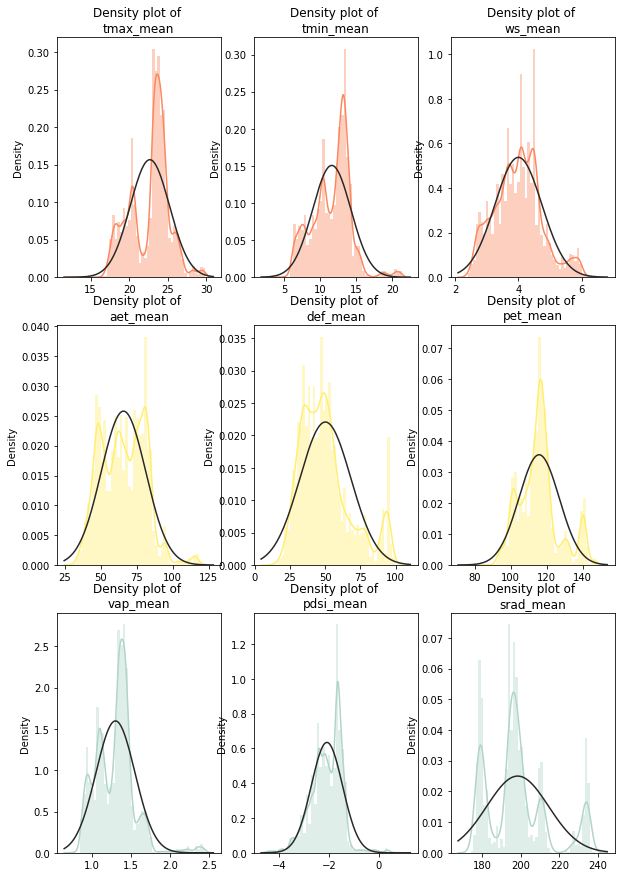

In [ ]:
from scipy.stats import norm

fig, ax = plt.subplots(3,3,figsize=(10,15))
colors = ['#FB8861','#ffee6f','#b1d5c8','#ee7959']
for i,feature in enumerate(features):
  sns.distplot(all_model_data[[feature]], ax=ax[i//3][i%3], fit=norm, color=colors[i//3])  # fit norm to see the distribution
  ax[i//3][i%3].set_title(f'Density plot of \n{feature}')
plt.show()

## Log transformation

In order to get a more normalized feature, log transformation is a common technique that is widely used in the industry.

We are going to use `skew()` to find statistically skewed features and applied log transformation on them.

In [ ]:
skew_columns = all_model_data[features].skew().sort_values(ascending=False)
skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

vap_mean     1.001214
def_mean     0.898288
srad_mean    0.822319
dtype: float32

In [ ]:
# transform the skewed cols into approximate norm
for col in skew_columns.index.tolist():
  all_model_data[f'log_{col}'] = np.log1p(all_model_data[col])  # apply log1p on the skewed cols
  all_model_data.drop(col, axis=1, inplace=True)  # remove the original cols

# check the transformation result
all_model_data.head()

,decimalLongitude,decimalLatitude,gbifID,eventDate,country,continent,stateProvince,species,occurrenceStatus,key,aet_mean,pdsi_mean,pet_mean,tmax_mean,tmin_mean,ws_mean,log_vap_mean,log_def_mean,log_srad_mean
0,150.794729,-34.071099,1571047876,2016-04-26,Australia,Australia,New South Wales,Crinia Signifera,0,2734,64.900002,-1.458333,117.199997,24.073336,12.021668,3.370000,0.844078,3.976249,5.282781
1,144.590426,-37.470250,3463514005,2018-09-04,Australia,Australia,Victoria,Crinia Signifera,0,2229,49.466667,-2.451667,103.633331,18.743338,7.730002,4.368333,0.666204,4.010661,5.200980
2,115.918000,-32.038200,3463552600,2018-07-24,Australia,Australia,Western Australia,Crinia Glauerti,0,974,48.150002,-2.536666,139.533340,24.386669,13.213336,4.463334,0.851646,4.526848,5.460011
3,150.873000,-34.409000,3463471045,2019-09-06,Australia,Australia,New South Wales,Crinia Signifera,0,3140,87.349998,-1.725000,114.099998,22.380001,12.128333,4.353333,0.843720,3.323236,5.264933
4,144.058136,-37.732237,3463538583,2019-10-21,Australia,Australia,Victoria,Crinia Signifera,0,491,47.983334,-2.651666,100.683334,18.304998,7.763335,4.566667,0.674304,3.984654,5.196192


# Modeling

Now that we have the data in a format appropriate for machine learning, we can begin training a model. 

We store the predictor variables in dataframe `X` and the response in the array `y`.

Variables used: ['tmax', 'tmin', 'ws', 'aet', 'def', 'pet', 'vap', 'pdsi', 'srad']

Class weights：1:1.5

In [ ]:
# Separate the predictor variables from the response
X = (
    all_model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
)
y = all_model_data.occurrenceStatus.astype(int)

X.shape, y.shape

((20455, 9), (20455,))

In [ ]:
# Here are the final features we used to train the model
X.head()

,aet_mean,pdsi_mean,pet_mean,tmax_mean,tmin_mean,ws_mean,log_vap_mean,log_def_mean,log_srad_mean
0,64.900002,-1.458333,117.199997,24.073336,12.021668,3.370000,0.844078,3.976249,5.282781
1,49.466667,-2.451667,103.633331,18.743338,7.730002,4.368333,0.666204,4.010661,5.200980
2,48.150002,-2.536666,139.533340,24.386669,13.213336,4.463334,0.851646,4.526848,5.460011
3,87.349998,-1.725000,114.099998,22.380001,12.128333,4.353333,0.843720,3.323236,5.264933
4,47.983334,-2.651666,100.683334,18.304998,7.763335,4.566667,0.674304,3.984654,5.196192


In [ ]:
y

0        0
1        0
2        0
3        0
4        0
        ..
20450    0
20451    0
20452    0
20453    0
20454    1
Name: occurrenceStatus, Length: 20455, dtype: int64

In [ ]:
from collections import Counter

Counter(y)  # the result shows the dataset is imbalanced

Counter({0: 14574, 1: 5881})

## Validation split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size = 0.2,
                            stratify = y,
                            shuffle = True,
                            random_state = 123)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## Scalling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_norm = scaler.fit_transform(X_train)  # fit on the training dataset

X_test_norm = scaler.transform(X_test)  # applied the transformation on the test dataset

In [ ]:
# import joblib
# joblib.dump(scaler, 'minmax_scalar')

['minmax_scalar']

## Build a model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# this simply sets up the model
model = Sequential()
# this is hidden layer 1 (learning the features)
model.add(Dense(64, activation='relu', input_shape=(X_train_norm.shape[1],))) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3)) # specify a percentage between 0 and 0.5
# this is hidden layer 2 (getting more complicated)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3)) # specify a percentage between 0 and 0.5
# this is hidden layer 3 (for prediction)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3)) # specify a percentage between 0 and 0.5
# this is the output node
model.add(Dense(1, activation='sigmoid'))  # using sigmoid function to produce probs
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [ ]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
			  loss='binary_crossentropy', 
			  metrics=['accuracy'])

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

history = model.fit(X_train_norm, y_train, 
          validation_data=(X_test_norm,y_test),
          class_weight=dict(enumerate([1,1.5])),  # 1:1.5
          epochs = 300, # train 300 epochs
          batch_size = 128, # with batch size of 128
          verbose=1, # 0 = dont show verbose, 1 = show it
          callbacks=[es])

Epoch 1/300
128/128 [==============================] - 4s 13ms/step - loss: 0.5610 - accuracy: 0.7534 - val_loss: 0.4312 - val_accuracy: 0.7194
Epoch 2/300
128/128 [==============================] - 2s 12ms/step - loss: 0.4848 - accuracy: 0.7826 - val_loss: 0.3945 - val_accuracy: 0.7961
Epoch 3/300
128/128 [==============================] - 2s 12ms/step - loss: 0.4701 - accuracy: 0.7903 - val_loss: 0.4284 - val_accuracy: 0.7233
Epoch 4/300
128/128 [==============================] - 1s 11ms/step - loss: 0.4652 - accuracy: 0.7934 - val_loss: 0.3808 - val_accuracy: 0.8005
Epoch 5/300
128/128 [==============================] - 1s 11ms/step - loss: 0.4601 - accuracy: 0.7941 - val_loss: 0.3808 - val_accuracy: 0.7996
Epoch 6/300
128/128 [==============================] - 1s 11ms/step - loss: 0.4559 - accuracy: 0.7967 - val_loss: 0.3960 - val_accuracy: 0.7485
Epoch 7/300
128/128 [==============================] - 1s 10ms/step - loss: 0.4528 - accuracy: 0.7960 - val_loss: 0.3757 - val_accuracy:

## Cross-Validation

In [ ]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
			  loss='binary_crossentropy', 
			  metrics=['accuracy'])

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

In [ ]:
n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
metric_params = {'F1': {}, 'Accuracy': {}}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X_train_norm, y_train)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    # Fit the model with the training set
    history = model.fit(X_train_norm[[train_index]], y_train[[train_index]], 
          validation_data=(X_train_norm[[test_index]], y_train[[test_index]]),
          class_weight=dict(enumerate([1,1.5])),  # 1:1.5
          epochs = 300, # train 300 epochs
          batch_size = 128, # with batch size of 128
          verbose=0, # 0 = dont show verbose, 1 = show it
          callbacks=[es])
    # Make the prediction and store the results
    predictions = model.predict(X_train_norm[[test_index]])>0.5
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_train[[test_index]], predictions, **metric_params[metric]))
        
    results['predicted'].extend(predictions)  # using extend to add a list of values
    results['actual'].extend(list(y_train[[test_index]]))

# Print out the average score of k-folds
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")


Fold 1 of 10
Restoring model weights from the end of the best epoch: 25.
Epoch 35: early stopping
Fold 2 of 10
Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
Fold 3 of 10
Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
Fold 4 of 10
Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping
Fold 5 of 10
Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping
Fold 6 of 10
Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
Fold 7 of 10
Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
Fold 8 of 10
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
Fold 9 of 10
Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping
Fold 10 of 10
Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping

Metrics averaged over 10

We did not save the original model that generated the prediction on the leaderboard. We trained a new model with the same structure, but the results would be slightly different due to the nature of neural networks.

In [ ]:
# model.save('./final_model.h5')

In [ ]:
# import pickle
# weights = model.get_weights()
# pklfile= './final_model.pkl'

# with open(pklfile, 'wb') as f:
#   pickle.dump(weights, f, protocol= pickle.HIGHEST_PROTOCOL)

## Results

From the confusion matrix below, we could see the model tends to predict more of the monority class due to a higher class weight, resulting in a high recall value. However, the precision on the minority class is relatively low.

Compared with the CV result, the accuracy score does not change very much. We could conclude the model is stable when predicting unseen data.

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2915
           1       0.66      0.74      0.70      1176

    accuracy                           0.82      4091
   macro avg       0.78      0.79      0.78      4091
weighted avg       0.82      0.82      0.82      4091



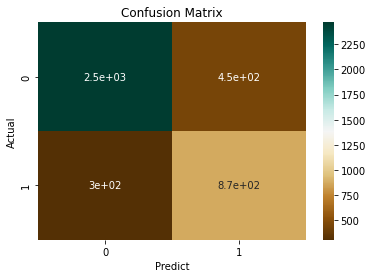

In [ ]:
y_pred = model.predict(X_test_norm)>0.5

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='BrBG')  # use cmap to adjust the design

plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

From the learning curve, we could see the model performance fluctuates during the training process. However, training loss does not show a significant decrease after around 25 epoches.

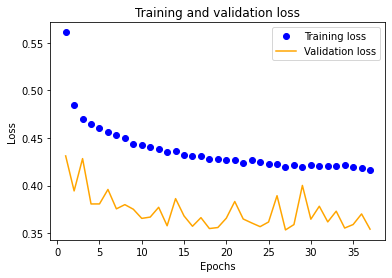

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()  # loss v.s. epochs

Generate probability heatmap (for Sydney area)

In [ ]:
skew_columns = ['vap_mean','def_mean','srad_mean']
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = (predictor_image.stack(z=("y", "x")).transpose().rename('data').sel(band=features).fillna(0)
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])[['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index=['x','y'],columns="band", values="val")
            )
    for col in skew_columns:
      predictor_image[f'log_{col}'] = np.log1p(predictor_image[col])  # apply log1p on the skewed cols
      predictor_image.drop(col, axis=1, inplace=True)  # remove the original cols

    predictor_image = predictor_image.loc[:,scaler.feature_names_in_]
    scaled_X = scaler.transform(predictor_image)
    predictor_image['probabilities'] = model.predict(scaled_X)

    return predictor_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(Sydney_weather_data, model)

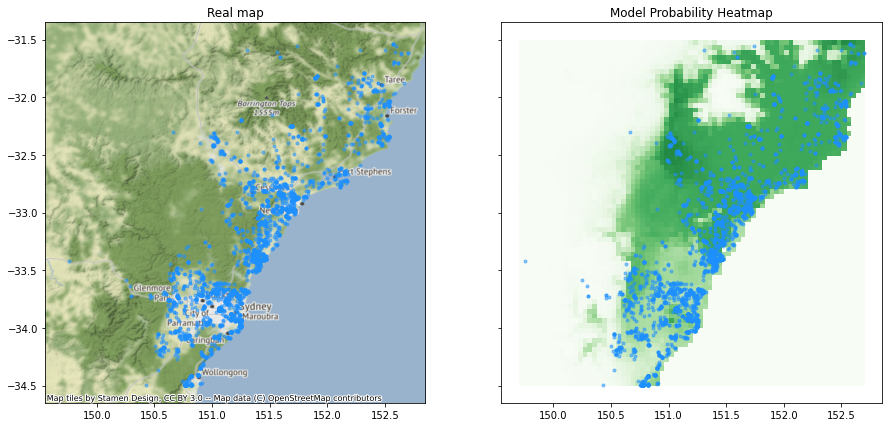

In [ ]:
Sydney_data = filter_bbox(all_model_data,(150.7-1, -33.5-1, 151.7+1, -32.5+1))
fig, ax = plt.subplots(1, 2, figsize = (15, 10), sharex=True, sharey=True)
ax[0].scatter(x=[resultant_image.x.min(),resultant_image.x.max()],y=[resultant_image.y.min(),resultant_image.y.max()],alpha=0)
cx.add_basemap(ax[0], crs={'init':'epsg:4326'})
ax[0].set_title('Real map')



plt.imshow(resultant_image[['x','y','probabilities']].pivot(index='y',columns='x',values='probabilities').sort_index(ascending=False),
           interpolation='none', vmin=0, vmax=1, cmap=plt.cm.Greens,
           extent=(resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()))
ax[1].set_aspect('equal')
ax[1].set_title('Model Probability Heatmap')

for i, axis in enumerate(ax):
  filt = Sydney_data.occurrenceStatus == 1
  axis.scatter(
      Sydney_data[filt].decimalLongitude, Sydney_data[filt].decimalLatitude, 
      color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
  )


plt.show()

## Reginal Prediction

In this section, we aim to find the drawbacks or shortcomings of the model. From the visualization in the previous section, we know the frog distribution varies across different locations. Some places are more populated by Litoria Fallax, some are less.

As we can see from the visualization below, the model performs well in some regions but poorly in other regions.

**We tried to build models that were trained separately on regional data (bu adjusting class weights based on the regional frog distribution), and combined those models together in making the final prediction. However, the method did not outperform current method.**

In [ ]:
from keras.models import load_model

# load model
model = load_model("./final_model.h5")

In [ ]:
def regional_preds(region,bbox):
  bbox = bbox
  filt = np.where((all_model_data.decimalLongitude >= bbox[0]) &
            (all_model_data.decimalLatitude >= bbox[1]) &
            (all_model_data.decimalLongitude <= bbox[2]) &
            (all_model_data.decimalLatitude <= bbox[3]))[0]
  regional_X = scaler.transform(X.iloc[filt,:])
  regional_y = y.iloc[filt]
  regional_preds = model.predict(regional_X)>0.5

  print(Counter(regional_preds.ravel()))
  print(classification_report(regional_y, regional_preds))

  conf_matrix = confusion_matrix(regional_y, regional_preds)
  fig, ax = plt.subplots(1,2,figsize=(10,5))
  sns.heatmap(conf_matrix, annot=True, cmap='BrBG', ax=ax[0])  # use cmap to adjust the design
  ax[0].set_xlabel('Predict')
  ax[0].set_ylabel('Actual')
  sns.heatmap(confusion_matrix(regional_y, regional_y), annot=True, cmap='BrBG', ax=ax[1])
  ax[1].set_xlabel('Predict')
  ax[1].set_ylabel('Actual')
  plt.suptitle('Confusion Matrix of {}'.format(region))
  plt.show()

### Sydney

The model performs fairly well when predicting frog occurrence in Sydney.

Counter({False: 6635, True: 3410})
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      6577
           1       0.57      0.56      0.56      3468

    accuracy                           0.70     10045
   macro avg       0.67      0.67      0.67     10045
weighted avg       0.70      0.70      0.70     10045



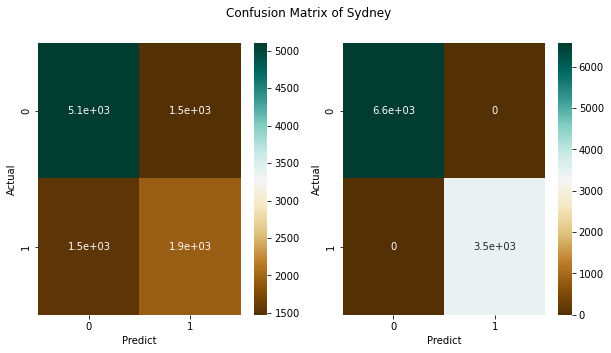

In [ ]:
regional_preds('Sydney',(150.7-1, -33.5-1, 151.7+1, -32.5+1))

### Melbourne

There are a few records of Litoria Fallax in Melbourne, but the model fails to predict and tend to ignore the minority class even if we gave higher weights on the minority class (Litoria Fallax).

Counter({False: 5576})
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5504
           1       0.00      0.00      0.00        72

    accuracy                           0.99      5576
   macro avg       0.49      0.50      0.50      5576
weighted avg       0.97      0.99      0.98      5576



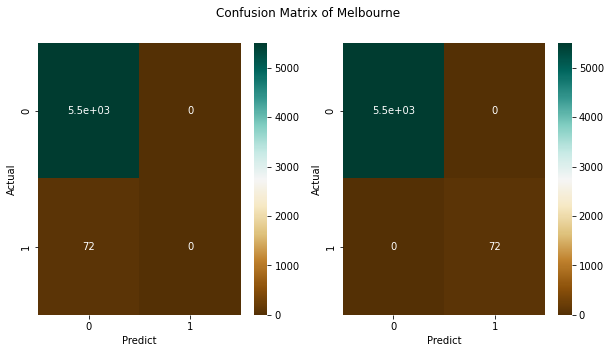

In [ ]:
regional_preds('Melbourne',(144.8-1, -38.5-1, 145.8+1, -37.5+1))

### Perth

The model captures the features of Perth very well.

Counter({False: 1941})
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1941

    accuracy                           1.00      1941
   macro avg       1.00      1.00      1.00      1941
weighted avg       1.00      1.00      1.00      1941



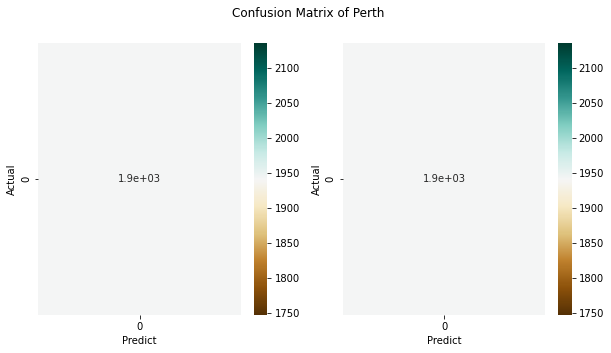

In [ ]:
regional_preds('Perth',(115.7-1, -32.5-1, 116.7+1, -31.5+1))

### Brisbane

Brisbane has a great amount of other frogs, while the model fails to predict and tend to ignore the minority class.

Counter({True: 2406, False: 20})
              precision    recall  f1-score   support

           0       0.80      0.03      0.06       506
           1       0.80      1.00      0.89      1920

    accuracy                           0.80      2426
   macro avg       0.80      0.51      0.47      2426
weighted avg       0.80      0.80      0.71      2426



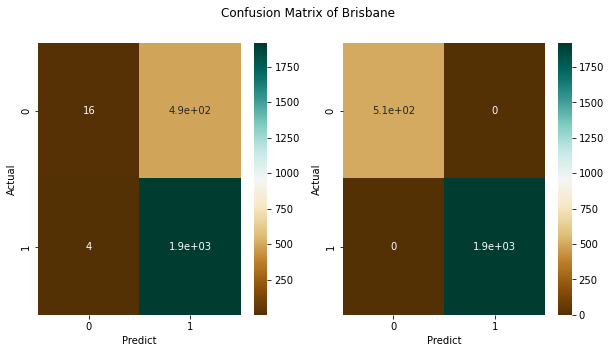

In [ ]:
regional_preds('Brisbane',(152.6-1, -29.0-1, 153.6+1, -28.0+1))

## Feature Importance

We use xgboost model to explore the feature importance because xgboost is robust and easy to understand. It would be more difficult to explain what's going on whithin a neural network. It's like a black box. On the other hand, tree-based model is easier to interpret and captures the feature importance well.

In [ ]:
import xgboost as xgb
from xgboost import plot_importance

class Simple_XGB:
  def __init__(self):
    self.params = {
            'booster': 'gbtree',
            'objective': 'binary:logistic',
            'gamma': 0.0,
            'max_depth': 6,
            'lambda': 2,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'min_child_weight': 3,
            'silent': 1,
            'eta': 0.1,
            'seed': 1000,
            'nthread': 4
            }
    self.y_labels = ['Not occurred', 'Occurred']
    self.X = (
          all_model_data
          .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
            'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
      )
    self.y = all_model_data.occurrenceStatus.astype(int)
  
  def _f1_eval(self, y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred), average='weighted')  # multiclass
    return 'f1_err', err
  
  def cal_sample_weights(self, target):
    return (lambda x: self.class_weights[x])(target)

  def split(self):
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X, self.y, 
                                          test_size=0.2,
                                          stratify=self.y,
                                          random_state=123)
  
  def train(self, num_rounds=400, early_stopping_rounds=10):
    # initialize data format
    self.dtrain = xgb.DMatrix(self.X_train, self.y_train)
    self.dval = xgb.DMatrix(self.X_val, self.y_val)
    # train the model
    self.model = xgb.train(self.params, self.dtrain, num_rounds,
              evals=[(self.dtrain,'train'),(self.dval,'vaild')],
              early_stopping_rounds=early_stopping_rounds, feval=self._f1_eval)

  
  def evaluation_report(self):
    # make prediction
    self.y_pred = self.model.predict(self.dval)>0.5  # generate prediction based on evaluation data
    # evaluate acc
    print(classification_report(self.y_val, self.y_pred, target_names=self.y_labels))
  
  def predict(self, X_test):
    self.dtest = xgb.DMatrix(X_test)
    self.prediction = self.model.predict(self.dtest)
    return self.prediction

Although xgboost gives a better prediction on the training dataset, it does not outperform neural network on the unseen dataset.

In [ ]:
clf = Simple_XGB()
clf.split()
clf.train()
clf.evaluation_report()

[0]	train-error:0.166341	vaild-error:0.176974	train-f1_err:0.171295	vaild-f1_err:0.180668
Multiple eval metrics have been passed: 'vaild-f1_err' will be used for early stopping.

Will train until vaild-f1_err hasn't improved in 10 rounds.
[1]	train-error:0.163713	vaild-error:0.175752	train-f1_err:0.168133	vaild-f1_err:0.179114
[2]	train-error:0.159741	vaild-error:0.177707	train-f1_err:0.164237	vaild-f1_err:0.181051
[3]	train-error:0.161269	vaild-error:0.179174	train-f1_err:0.164182	vaild-f1_err:0.181141
[4]	train-error:0.15913	vaild-error:0.17013	train-f1_err:0.161214	vaild-f1_err:0.170793
[5]	train-error:0.160535	vaild-error:0.176241	train-f1_err:0.162763	vaild-f1_err:0.177236
[6]	train-error:0.161085	vaild-error:0.174041	train-f1_err:0.162531	vaild-f1_err:0.174308
[7]	train-error:0.159313	vaild-error:0.175018	train-f1_err:0.1615	vaild-f1_err:0.176079
[8]	train-error:0.158519	vaild-error:0.173796	train-f1_err:0.161023	vaild-f1_err:0.175455
[9]	train-error:0.155463	vaild-error:0.168174

In [ ]:
clf.train(11)

[0]	train-error:0.166341	vaild-error:0.176974	train-f1_err:0.171295	vaild-f1_err:0.180668
Multiple eval metrics have been passed: 'vaild-f1_err' will be used for early stopping.

Will train until vaild-f1_err hasn't improved in 10 rounds.
[1]	train-error:0.163713	vaild-error:0.175752	train-f1_err:0.168133	vaild-f1_err:0.179114
[2]	train-error:0.159741	vaild-error:0.177707	train-f1_err:0.164237	vaild-f1_err:0.181051
[3]	train-error:0.161269	vaild-error:0.179174	train-f1_err:0.164182	vaild-f1_err:0.181141
[4]	train-error:0.15913	vaild-error:0.17013	train-f1_err:0.161214	vaild-f1_err:0.170793
[5]	train-error:0.160535	vaild-error:0.176241	train-f1_err:0.162763	vaild-f1_err:0.177236
[6]	train-error:0.161085	vaild-error:0.174041	train-f1_err:0.162531	vaild-f1_err:0.174308
[7]	train-error:0.159313	vaild-error:0.175018	train-f1_err:0.1615	vaild-f1_err:0.176079
[8]	train-error:0.158519	vaild-error:0.173796	train-f1_err:0.161023	vaild-f1_err:0.175455
[9]	train-error:0.155463	vaild-error:0.168174

The feature importance plot gives valuable insights on how these features affect the model. Wind speed, Shortwave Radiation, and Actual Evapotranspiration do appear with high variation across Australia. Surprisingly max temperature is way more important than min temperature. 

Both Reference Evapotranspiration and Actual Evapotranspiration show great importance in the xgboost model because these features affect Litoria Fallax's living environment directly, and so does wind speed.

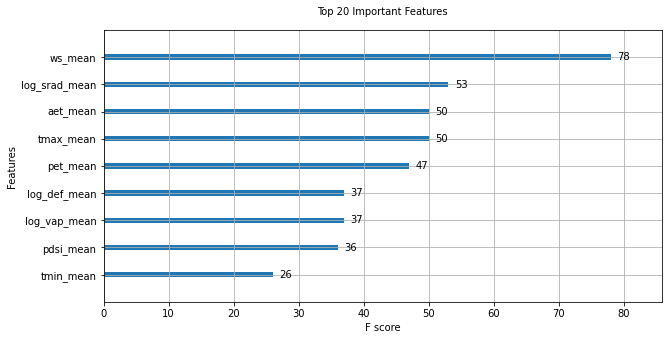

In [ ]:
plot_importance(clf.model, max_num_features=9)
plt.gcf().set_size_inches(10,5)
plt.gca().set_title('Top 20 Important Features',fontsize=10, pad=15)
plt.savefig('feature_importance.png')
plt.show()

# Conclusion

1. The model performance relies heavily on the hypothesis space of the training dataset. We utilized spatial and temporal sampling techniques that immensely helped the model training process.
2. We have chosen to use Deep Learning models. Their complex structures could learn the linear and nonlinear attributes of the features. In practice, Dense Neural Networks are robust and good at generalization. The cross-validation procedure has proven the model's stability.
3. The model predicts well on a large scale but fails to address the class imbalance problem in finer granularity.
4. The model can be implemented in predicting frog occurrence. Since the frog is highly sensitive to climate change, a change in the species distribution would indicate a potential shift in environmental conditions or biodiversity.
5. We have learned in this project that it is not always effective to fine-tune the model, especially for Dense Neural Networks. A DNN with a simple structure is enough to capture the information in the features. We must be creative about sampling and feature engineering to approach the class imbalance problem. Going through the visualizations, we found many target frogs live close to other species. It would be difficult for the model to tell such a minor difference in the predictor variables. In this situation, field knowledge would be more suitable for explaining.

In [ ]:
# !pip freeze > final_requirements.txt